In [6]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

In [7]:
results_dir = 'nested_cv'

In [8]:
# make a barplot to compare model AUCs.

results = []
for cv_run in os.listdir(results_dir):
    try:
        metrics = pd.read_csv(os.path.join(results_dir, cv_run, 'test_performances.csv'), index_col=[0,1])
        results.append(metrics)
    except FileNotFoundError:
        pass

test_performances = results[0].join(results[1:])

In [9]:
test_performances

SVC        RF  f_logreg  f_logreg_smote  chemical
1 4  0.864660  0.830662  0.864143        0.827393  0.603144
  2  0.870188  0.854480  0.871651        0.840151  0.613644
  0  0.844233  0.873784  0.859043        0.815711  0.635962
  3  0.869558  0.834556  0.867262        0.829310  0.590754
4 1  0.904921  0.961269  0.944526        0.927391  0.680253
  2  0.860610  0.954884  0.931655        0.894903  0.713497
  0  0.917797  0.964887  0.946775        0.943707  0.696543
  3  0.891392  0.950796  0.944838        0.930685  0.726203
2 1  0.820877  0.858079  0.818032        0.811300  0.651992
  4  0.804997  0.855658  0.808415        0.808155  0.664748
  0  0.819899  0.861364  0.823140        0.818300  0.720336
  3  0.801818  0.840868  0.815611        0.818399  0.660478
0 1  0.888382  0.871794  0.897408        0.884776  0.544046
  4  0.897191  0.882410  0.903652        0.900527  0.441085
  2  0.883893  0.885074  0.893778        0.907413  0.544761
  3  0.878407  0.880492  0.887349        0.886020  0.505062
3 1  0.881405  0.861215  0.890555        0.886002  0.635835
  4  0.884499  0.858587  0.886942        0.891737  0.711198
  2  0.868893  0.858393  0.879404        0.901151  0.661713
  0  0.871636  0.872198  0.877091        0.876956  0.630653

(0.6, 0.92)

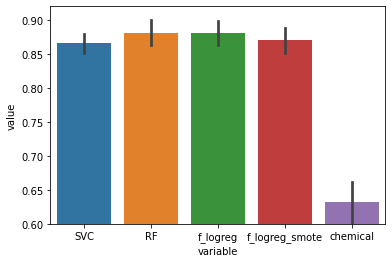

In [11]:
sns.barplot(data=test_performances.melt(), x='variable', y='value')
plt.ylim(0.6,0.92)

In [12]:
def make_features_numerical(df: pd.DataFrame) -> pd.DataFrame:
    '''Cannot train on boolean values.'''
    df = df.copy()
    for column in df.columns:
        if df[column].dtype == bool:
            df[column] = df[column].astype(int)

    return df

In [13]:
df = pd.read_pickle('mouse_features_paper.pickle')
feature_columns = df.columns[df.columns.get_level_values(0).str.startswith('MS')]

In [14]:
def add_test_probabilities(df, cv_run: str, results_dir: str, folds = [0,1,2,3,4], model_type='sklearn_any'):

    for test in folds:
        # extract the features.
        df_X = df.loc[df[('Annotations', 'Fold')] == test, feature_columns]
        df_X = make_features_numerical(df_X)
        X =  df_X.values

        all_probs = []
        # predict from all the test models and average probabilities.
        for val in folds:
            if val == test:
                continue

            model = pickle.load(open(os.path.join(results_dir, cv_run, f'model_t{test}_v{val}.pkl'), 'rb'))
            
            # TODO adjust for SVM and bayes logreg
            if model_type == 'svc':
                probs = model.decision_function(X)
            else:
                probs = model.predict_proba(X)[:, 1]
            
            all_probs.append(probs)

        probs = np.stack(all_probs).mean(axis=0)
        df.loc[df[('Annotations', 'Fold')] == test, ('Predictions', cv_run)] = probs

In [16]:
feature_columns = df.columns[df.columns.get_level_values(0).str.startswith('MS')]
add_test_probabilities(df, 'cv_f_logreg', results_dir )
add_test_probabilities(df, 'cv_f_logreg_smote', results_dir )
add_test_probabilities(df, 'cv_rf', results_dir )
add_test_probabilities(df, 'cv_svc', results_dir, model_type='svc' )
feature_columns = df.columns[df.columns.get_level_values(0).str.startswith('Chemical')]
add_test_probabilities(df, 'cv_chemical', results_dir )

In [17]:
import seaborn as sns; sns.set()

def make_plottable(prediction, targets, source, model_name, auc=True):
    plot_data = pd.DataFrame({"prediction": prediction, "Target": targets.astype(int)})
    plot_data = plot_data.sort_values(by="prediction")[::-1]
    plot_data["Top X"] = np.arange(targets.shape[0])
    plot_data["Found"] = plot_data["Target"].cumsum()
    plot_data["source"] = source
    if auc:
        auc = sklearn.metrics.roc_auc_score(targets.astype(int),  prediction)
        model_name = "{} (AUC={:.3f})".format(model_name, auc)
    plot_data["model"] = model_name
    return plot_data

df_plot = pd.concat((
    make_plottable(df[('Predictions', 'cv_f_logreg')].values, df[('Annotations', 'Known')].cat.codes.values, "Observed", "Logistic regression"),
    make_plottable(df[('Predictions', 'cv_rf')].values, df[('Annotations', 'Known')].cat.codes.values, "Observed", "Random forest"),
    make_plottable(df[('Annotations', 'Intensity')].values, df[('Annotations', 'Known')].cat.codes.values, "Observed", "Null"),
    make_plottable(df[('Predictions', 'cv_svc')].values, df[('Annotations', 'Known')].cat.codes.values, "Observed", "Support vector machine"),
    make_plottable(df[('Predictions', 'cv_f_logreg_smote')].values, df[('Annotations', 'Known')].cat.codes.values, "Observed", "Logistic regression w/ SMOTE"),
    make_plottable(df[('Predictions', 'cv_chemical')].values, df[('Annotations', 'Known')].cat.codes.values, "Observed", "Chemical model"),

)).reset_index(drop=True) # need to reset the index for seaborn to work correctly.

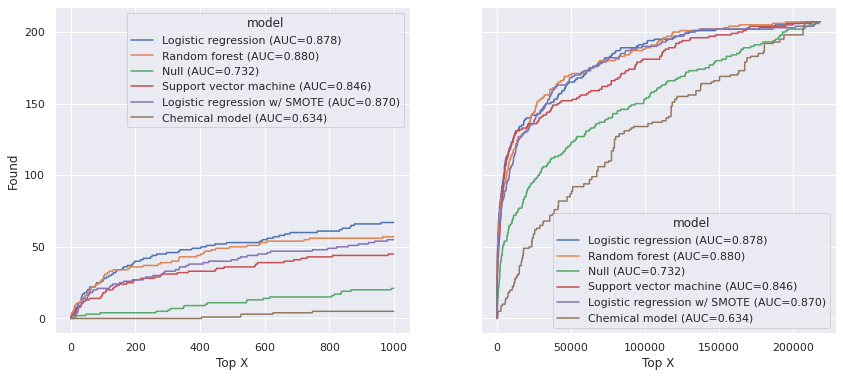

In [18]:
fig = plt.figure(figsize=(2 * 7, 6))
ax1, ax2 = fig.subplots(1, 2, sharey=True)
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.lineplot(x="Top X", y="Found", hue="model", data=df_plot[df_plot["Top X"] < 1000], ax=ax1)
# sns.lineplot(x="Top X", y="Found", style="model", data=df[df["Top X"] < 1000], ax=ax2)
g = sns.lineplot(x="Top X", y="Found", hue="model", data=df_plot, ax=ax2)
#g.axes.scatter(n_lpv, n_lpv_true, s=50, c='b', marker='x')
#g.axes.annotate('LPV', (n_lpv, n_lpv_true), xycoords='data',
#                xytext=(n_lpv * 1.25, n_lpv_true * 0.75), textcoords='data',
#                arrowprops=dict(arrowstyle= '->', color='k', lw=3.5, ls='--'))
#g.figure.savefig("figures/report/top_panel.pdf")